In [120]:
import pandas as pd
from patsy import dmatrices
import matplotlib.pyplot as plt
import math as m
import numpy as np
import seaborn as sns
import statsmodels as sm
import statsmodels.api as sma
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
sns.set()

In [121]:
def growth_rate_to_doubling_time(growth_rates):
    return np.sign(growth_rates) * (np.log(2) / (np.sign(growth_rates) * growth_rates))

def doubling_time_to_growth_rate(doubling_times):
    return np.sign(doubling_times) * ( np.log(2) / (np.sign(doubling_times) * doubling_times))

In [122]:
data = pd.read_excel("../../Data/Simulation Results/growth rates with test delays.xlsx", index_col = 0)
days_simulated = 25

In [123]:
data

,hazard_rate_scale,infection_reporting_prob,contact_tracing_success_prob,contact_trace_delay_par,global_contact_reduction,two_step_tracing,prob_has_trace_app,test_delay_mean,0,1,...,15,16,17,18,19,20,21,22,23,24
0,0.215233,0.1,0.752671,2.441396,0.439195,False,0.403166,1.254872,5000,5010,...,43399,49247,55670,62741,70684,79388,88889,99517,111228,124019
1,0.215233,0.1,0.827470,2.333029,0.122284,False,0.379154,1.965839,5000,5021,...,94739,115264,139634,169106,204636,247116,298758,360095,433295,521138
2,0.222421,0.2,0.714802,1.590426,0.380185,False,0.404374,1.711538,5000,5014,...,50937,58257,66367,75287,85152,96143,108613,122096,137159,153499
3,0.236797,0.4,0.905765,1.906771,0.827327,False,0.000700,1.709373,5000,5011,...,13087,13396,13725,14007,14258,14496,14672,14812,14962,15131
4,0.243986,0.5,0.898859,1.821009,0.083892,False,0.209804,1.633454,5000,5024,...,102324,122529,145842,172848,204259,240661,283269,331907,388027,452798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.236797,0.4,0.773150,2.447001,0.037800,True,0.363323,1.963838,5000,5020,...,112672,136364,164785,197815,237328,283636,337962,401854,477329,565646
96,0.236797,0.4,0.908261,1.695124,0.730135,True,0.109673,1.247356,5000,5006,...,17238,17937,18613,19237,19764,20274,20756,21186,21563,21912
97,0.229609,0.3,0.803743,1.530201,0.893014,True,0.450742,1.662549,5000,5001,...,10891,11067,11240,11378,11521,11610,11701,11786,11849,11915
98,0.222421,0.2,0.850440,2.159865,0.694576,True,0.482363,1.296225,5000,5005,...,20148,21368,22585,23783,24944,26069,27166,28170,29162,30182


In [124]:
infection_counts = [str(i) for i in range(days_simulated)]
infection_counts = data[infection_counts]

Text(0.5, 1.0, 'Total Infected')

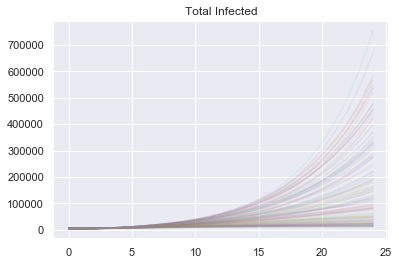

In [125]:
for _ in range(data.shape[0]):
    plt.plot(range(days_simulated), infection_counts.iloc[_], alpha = 0.1)
plt.title("Total Infected")

Text(0.5, 1.0, '$log_2$(Total Infected)')

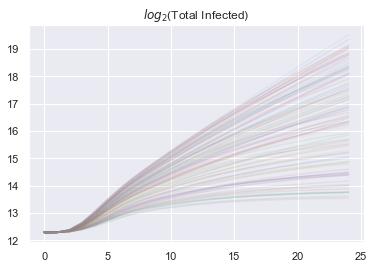

In [126]:
for _ in range(data.shape[0]):
    plt.plot(range(days_simulated), infection_counts.iloc[_].apply(lambda x: np.log2(x)), alpha = 0.1)
plt.title("$log_2$(Total Infected)")

Text(0.5, 1.0, 'Infection Incidence')

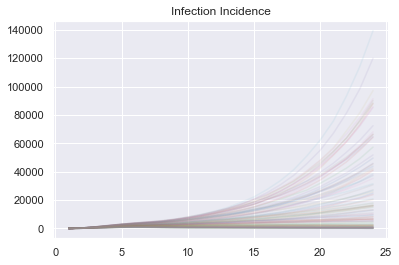

In [127]:
for _ in range(data.shape[0]):
    plt.plot(range(days_simulated), infection_counts.iloc[_].diff(1), alpha = 0.1)
plt.title("Infection Incidence")

Text(0.5, 1.0, 'Infection Incidence (10 epidemics)')

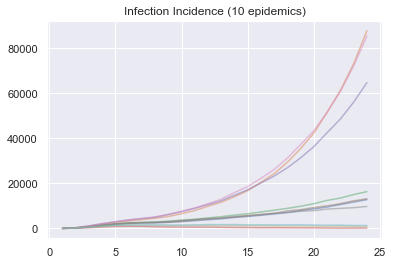

In [128]:
for _ in range(10):
    plt.plot(range(days_simulated), infection_counts.iloc[_].diff(1), alpha = 0.5)
plt.title("Infection Incidence (10 epidemics)")

Text(0.5, 1.0, '$Log_e$(Case Incidence) (14 epidemics)')

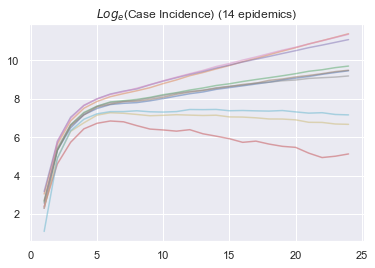

In [129]:
for _ in range(10):
    plt.plot(range(days_simulated), infection_counts.iloc[_].diff(1).apply(lambda x: np.log(x)), alpha = 0.5)
plt.title("$Log_e$(Case Incidence) (14 epidemics)")
#plt.savefig("Figures/Log_case_incidence.png")

We can see the variance begins to increase for the exponentially decaying epidemcis as they near 0. In order to get good estimation for the epidemics, we icnrease the starting number of infections. In this experiment, we start with 5000 infected, let the process run for 10 days, and then estimated the growth rate using days 10-30.

In [130]:
log_diff = infection_counts.iloc[_].diff(1).apply(lambda x: np.log(x))

data_set_up = {
    "log_case_incidence": log_diff[10:days_simulated],
    "time": list(range(10, days_simulated))
}
dataframe = pd.DataFrame(data_set_up)

OLS Regression Results                            
Dep. Variable:     log_case_incidence   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.463
Method:                 Least Squares   F-statistic:                     13.05
Date:                Sat, 20 Jun 2020   Prob (F-statistic):            0.00316
Time:                        16:30:49   Log-Likelihood:                 20.993
No. Observations:                  15   AIC:                            -37.99
Df Residuals:                      13   BIC:                            -36.57
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.5711      0.067    112.631      0.000       7.426       7.716
t

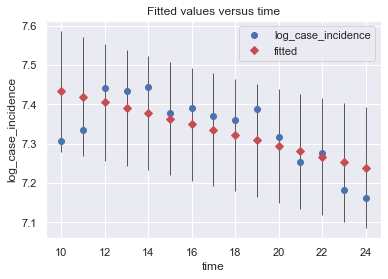

In [131]:
y, X = dmatrices('log_case_incidence ~ time', 
                 data = dataframe)
model = sma.OLS(y, X)
res = model.fit()
print(res.summary())
fig = sm.graphics.regressionplots.plot_fit(res, 1)
print(f"doublign time = {m.log(2)/res.params[1]}")

In [132]:
data_subset = infection_counts

In [133]:
growth_rates = []
for _ in range(data_subset.shape[0]):
    print(f"current fit; {_}", end = "\r")
    
    log_diff = data_subset.iloc[_].diff(1).apply(lambda x: np.log(x))

    data_set_up = {
        "log_case_incidence": log_diff[10:25],
        "time": list(range(10, 25))
    }
    dataframe = pd.DataFrame(data_set_up)
    dataframe = pd.DataFrame(data_set_up)
    
    y, X = dmatrices('log_case_incidence ~ time', 
                     data = dataframe)
    model = sma.RLM(y, X)
    res = model.fit()
    growth_rates.append(res.params[1])

    if res.params[1] == -float("inf"):
        print(f"missing data in line {_}")

current fit; 99

In [134]:
x = pd.Series(growth_rates) # 200 values
#x = x[x.between(x.quantile(.05), x.quantile(.95))] # without outliers

Text(0.5, 1.0, 'Distribution of Growth Rates')

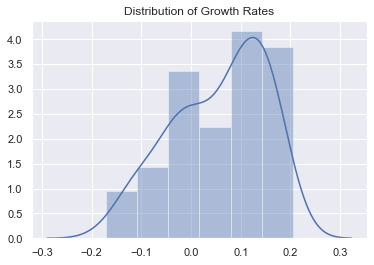

In [135]:
sns.distplot(x)
plt.title("Distribution of Growth Rates")

In [136]:
data_pars = data[data.columns[0:9]]
growth_rate_series = pd.Series(growth_rates)
data_pars["growth_rate"] = growth_rate_series

In [137]:
data_pars

,hazard_rate_scale,infection_reporting_prob,contact_tracing_success_prob,contact_trace_delay_par,global_contact_reduction,two_step_tracing,prob_has_trace_app,test_delay_mean,0,growth_rate
0,0.215233,0.1,0.752671,2.441396,0.439195,False,0.403166,1.254872,5000,0.101255
1,0.215233,0.1,0.827470,2.333029,0.122284,False,0.379154,1.965839,5000,0.184587
2,0.222421,0.2,0.714802,1.590426,0.380185,False,0.404374,1.711538,5000,0.106652
3,0.236797,0.4,0.905765,1.906771,0.827327,False,0.000700,1.709373,5000,-0.107690
4,0.243986,0.5,0.898859,1.821009,0.083892,False,0.209804,1.633454,5000,0.152982
...,...,...,...,...,...,...,...,...,...,...
95,0.236797,0.4,0.773150,2.447001,0.037800,True,0.363323,1.963838,5000,0.168933
96,0.236797,0.4,0.908261,1.695124,0.730135,True,0.109673,1.247356,5000,-0.076874
97,0.229609,0.3,0.803743,1.530201,0.893014,True,0.450742,1.662549,5000,-0.138007
98,0.222421,0.2,0.850440,2.159865,0.694576,True,0.482363,1.296225,5000,-0.016717


OLS Regression Results                            
Dep. Variable:            growth_rate   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     1754.
Date:                Sat, 20 Jun 2020   Prob (F-statistic):           4.91e-97
Time:                        16:30:51   Log-Likelihood:                 353.66
No. Observations:                 100   AIC:                            -687.3
Df Residuals:                      90   BIC:                            -661.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           

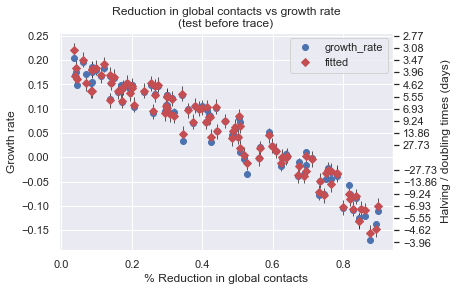

In [138]:
y, X = dmatrices('growth_rate ~ global_contact_reduction + I(global_contact_reduction**2) + I(global_contact_reduction**3) + I(prob_has_trace_app**2) +  contact_tracing_success_prob + contact_trace_delay_par + contact_trace_delay_par + infection_reporting_prob + two_step_tracing + test_delay_mean', 
                 data = data_pars)
model_2 = sma.OLS(y, X)
res = model_2.fit()
print(res.summary())

fig, ax = plt.subplots()

plot = sm.graphics.regressionplots.plot_fit(res, "global_contact_reduction", ax = ax)

y_vals = np.linspace(-0.175, 0.25, 18)
y_vals = np.concatenate((y_vals[:7], y_vals[8:]))

ax2 = ax.secondary_yaxis("right",
                         functions=(growth_rate_to_doubling_time,
                                    doubling_time_to_growth_rate))
ax2.set_ticks(growth_rate_to_doubling_time(y_vals), minor = False)

plt.xlabel("% Reduction in global contacts")
plt.ylabel("Growth rate")
plt.title("Reduction in global contacts vs growth rate\n(test before trace)")
ax2.set_ylabel("Halving / doubling times (days)")
plt.savefig("../../Figures/Simulation - test delay/growth_rate_global_contacts.png", bbox_inces = 'tight')
plt.savefig("../../Figures/Simulation - test delay/growth_rate_global_contacts.svg", bbox_inces = 'tight')

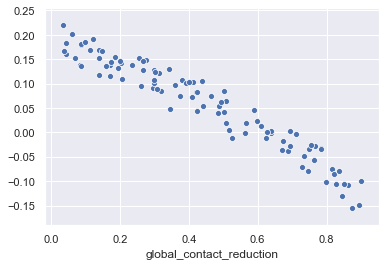

In [139]:
sns.scatterplot(data_pars["global_contact_reduction"], res.fittedvalues)

## Residuals vs Fitted Value

There doesn't appear to be any systematic deviation from our predicted value

Text(0, 0.5, 'Residual')

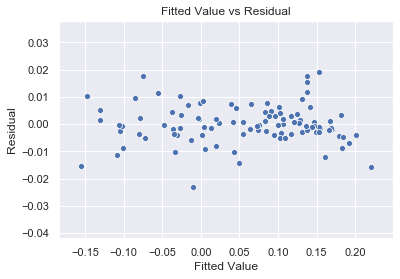

In [140]:
sns.scatterplot(res.fittedvalues, res.resid)
plt.title("Fitted Value vs Residual")
plt.xlabel("Fitted Value")
plt.ylabel("Residual")

## Residual Distribution

Text(0.5, 1.0, 'Distribution of the residuals')

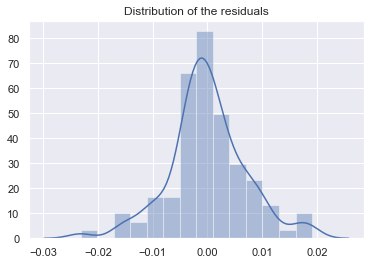

In [141]:
sns.distplot(res.resid)
plt.title("Distribution of the residuals")

# Comparison to reference distribution

In [142]:
reference_coefs = pd.read_excel("../../Data/Reference/OLS_coefficients.xlsx", index_col = 0)
reference_coefs

,intercept,coef_contact_reduction,coef_contact_reduction**2,coef_contact_reduction**2.1
0,0.22251,-0.255676,0.123382,-0.286964


In [143]:
c = reference_coefs["intercept"].loc[0]
beta_0 = reference_coefs["coef_contact_reduction"].loc[0]
beta_1 = reference_coefs["coef_contact_reduction**2"].loc[0]
beta_2 = reference_coefs["coef_contact_reduction**2.1"].loc[0]
x = np.linspace(0, 0.9)
y = c + beta_0*x + beta_1*x**2 + beta_2*x**3

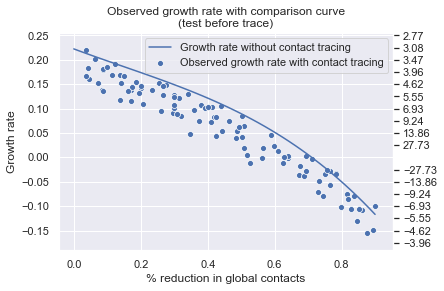

In [144]:

fig, ax = plt.subplots()

sns.scatterplot(data_pars["global_contact_reduction"], res.fittedvalues)
plt.plot(x, y)
plt.legend(("Growth rate without contact tracing", "Observed growth rate with contact tracing"))
plt.title("Observed growth rate with comparison curve\n(test before trace)")
plt.ylabel("Growth rate")
plt.xlabel("% reduction in global contacts")


y_vals = np.linspace(-0.175, 0.25, 18)
y_vals = np.concatenate((y_vals[:7], y_vals[8:]))

ax2 = ax.secondary_yaxis("right",
                         functions=(growth_rate_to_doubling_time,
                                    doubling_time_to_growth_rate))
ax2.set_ticks(growth_rate_to_doubling_time(y_vals), minor = False)



plt.savefig("../../Figures/Simulation - test delay/growth_rate_comparison.svg", bbox_inces = 'tight')
plt.savefig("../../Figures/Simulation - test delay/growth_rate_comparison.png", bbox_inces = 'tight')